In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data

To avoid features being derived from other features split the data into subsets *mean_* and *percent_* features.

In [8]:
global df
df = pd.read_csv("./data/processed/raw.csv")
df.drop(["school", "q1", "q3", "grade"], axis=1, inplace=True)
X = df.drop(["name", "event", "place", "all_american", "score"], axis=1)
# Revisit part 2 and scale count
X["year"] /= 4

y_score = df["score"]
y_all_am = df["all_american"]

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["event_num"] = le.fit_transform(df["event"])

In [10]:
# Prepare scaled data for later
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns = list(X.columns[:-1]) # Year scaling is dividing by 4
X_scaled_np = scaler.fit_transform(X.drop(["year"], axis=1))
X_scaled = pd.DataFrame(X_scaled_np, columns=columns)
#X_scaled = pd.concat([df[["all_american", "score"]], X_scaled, df["year"]], axis=1)
X_scaled = pd.concat([X_scaled, df["year"]], axis=1)

In [11]:
# Count ranges up to 75 so scale this down in original data
X["count"] = X_scaled["count"].copy()

# Baseline

Given that there are 24 athletes competing in an event but only 8 place All-American the completely random chance of guessing correctly is 1/3. I want to create a custom metric which shows how many of the top 8 were predicted correctly for each event. By doing so, we can make a more intelligent baseline if we simply predict the top 8 athletes in an event based on a given feature to win.

In [12]:
def percent_all_american_score(y_true, y_pred, indices=df.index):
    truth = df.iloc[indices][["name", "event", "place", "all_american"]].copy()
    truth["prob_all_am"] = y_pred
    top_eight = truth.sort_values(["event", "prob_all_am"], ascending=False).groupby(["event"]).head(8)
    return sum(top_eight["all_american"]) / len(top_eight)

single_feature_scores = [(feature, round(percent_all_american_score(None, X[feature]), 3)) for feature in X.columns]
print(sorted(single_feature_scores, key=lambda tup: tup[1], reverse=True)[:5])

[('mean_three_best', 0.729), ('max', 0.681), ('median', 0.59), ('mean', 0.576), ('mean_three_recent', 0.576)]


So, my feature engineered `mean_three_best` alone nearly 73 percent accurate! If the models can not beat *0.729* we can determine that either 1) we need to collect more data and/or features or 2) this problem is not well suited to machine learning.

In [13]:
from sklearn.metrics import make_scorer
all_am_accuracy = make_scorer(percent_all_american_score, needs_proba=True, indices=df.index)

# Dimensionality Reduction

### Correlation
First, we check if any features are highly correlated

In [14]:
X_correlations = df.drop(["name", "place", "event_num"], axis=1).corr()
X_correlations.columns = [
    'all_am', 'min', 'max', 'mean', 'std', 'median',
    'mean_3_recent', 'mean_3_best', 'mean_3_worst',
    'pd_recent_best', 'pd_recent_worst', 'no_mark_rate',
    'count', 'year', 'score'
] # To fit the dataframe on screen
X_correlations[abs(X_correlations) > 0.4]

,all_am,min,max,mean,std,median,mean_3_recent,mean_3_best,mean_3_worst,pd_recent_best,pd_recent_worst,no_mark_rate,count,year,score
all_american,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.814729
min,NaN,1.000000,0.746160,0.868393,-0.863812,0.839157,0.868393,0.757867,0.958043,-0.742832,-0.834228,NaN,NaN,NaN,NaN
max,NaN,0.746160,1.000000,0.945981,NaN,0.941817,0.945981,0.979613,0.832441,-0.402534,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.868393,0.945981,1.000000,-0.608691,0.994070,1.000000,0.957523,0.951560,-0.633585,-0.566721,NaN,NaN,NaN,NaN
std,NaN,-0.863812,NaN,-0.608691,1.000000,-0.565123,-0.608691,-0.427707,-0.791583,0.805915,0.915533,NaN,NaN,NaN,NaN
median,NaN,0.839157,0.941817,0.994070,-0.565123,1.000000,0.994070,0.956692,0.930132,-0.616570,-0.517846,NaN,NaN,NaN,NaN
mean_three_recent,NaN,0.868393,0.945981,1.000000,-0.608691,0.994070,1.000000,0.957523,0.951560,-0.633585,-0.566721,NaN,NaN,NaN,NaN
mean_three_best,NaN,0.757867,0.979613,0.957523,-0.427707,0.956692,0.957523,1.000000,0.841396,NaN,NaN,NaN,NaN,NaN,NaN
mean_three_worst,NaN,0.958043,0.832441,0.951560,-0.791583,0.930132,0.951560,0.841396,1.000000,-0.786998,-0.789165,NaN,NaN,NaN,NaN
percent_diff_recent_best,NaN,-0.742832,-0.402534,-0.633585,0.805915,-0.616570,-0.633585,NaN,-0.786998,1.000000,0.861893,NaN,0.557427,NaN,NaN


Observations
- The min, max, mean, and median are highly correlated as expected. Consider selecting only one of the four.
- The three *mean_* features highly correlated with min, max, mean, and median so they may not be very descriptive
- The *percent_diff*  features have a strong negative correlation with min, max, mean, median
- The *percent_diff*  features are highly correlated with standard deviation and count which was not expected

Because the `min, max, median`,  `mean_three_recent, mean_three_best, mean_three_worst`, and `percent_diff_recent_best, percent_diff_recent_worst` feature groups are so strongly correlated I will pick only one based on the strongest correlation to target. This additionally lightens the problem of the percent_diff features being linear combinations of the mean_ features.

In [15]:
# Observe which features correlate best with target
X_correlations["score"]

all_american                 0.814729
min                          0.122397
max                          0.286176
mean                         0.207847
std                          0.034175
median                       0.208468
mean_three_recent            0.207847
mean_three_best              0.268128
mean_three_worst             0.138837
percent_diff_recent_best     0.054832
percent_diff_recent_worst    0.036084
no_mark_rate                -0.148302
count                        0.122951
year                         0.035511
score                        1.000000
Name: score, dtype: float64

Here, the `max, mean_three_best, percent_diff_recent_best` features win their groups respectively and so based on correlation our feature reduced data will be

In [16]:
# Thus by correlation the feature reduced data would be max, std, percent_diff_recent_best, no_mark_rate, count, and year
# = df[["event", "all_american", "score", "max", "std", "percent_diff_recent_best", "no_mark_rate", "count", "year"]]
X_fr_corr = X[["max", "std", "mean_three_best", "percent_diff_recent_best", "no_mark_rate", "count", "year"]]
X_fr_corr.head(5)

,max,std,mean_three_best,percent_diff_recent_best,no_mark_rate,count,year
0,0.982000,0.011727,0.979063,0.013292,0.0,0.180556,0.50
1,1.003064,0.011425,0.974206,0.000230,0.0,0.083333,0.25
2,0.974206,0.015418,0.974206,0.015742,0.0,0.180556,0.50
3,0.987928,0.013936,0.979063,0.013061,0.0,0.208333,0.75
4,0.979063,0.011750,0.972277,0.011381,0.0,0.194444,1.00


## Decision Tree Feature Importance

In [17]:
from sklearn.tree import DecisionTreeClassifier

In [18]:
dt_features = DecisionTreeClassifier(random_state=0, class_weight="balanced")
dt_features.fit(X, y_all_am)
print(sorted([(pair[0], round(pair[1], 3)) for pair in zip(X.columns, dt_features.feature_importances_)], reverse=True, key=lambda tup: tup[1]))

[('max', 0.242), ('percent_diff_recent_best', 0.135), ('percent_diff_recent_worst', 0.132), ('min', 0.093), ('std', 0.067), ('count', 0.066), ('mean_three_recent', 0.062), ('mean_three_worst', 0.054), ('no_mark_rate', 0.047), ('mean_three_best', 0.044), ('median', 0.031), ('year', 0.015), ('mean', 0.011)]


The feature importance values here align with what we found in the correlation tests. Namely, max is the most important feature with count and percent_diff_recent_best also being relevant. So, if we combine what we know so far a feature reduced dataset should only include the columns `max, std, percent_diff_recent_best, no_mark_rate, count, year`. Given this, there is no change to the feature reduced dataset

In [19]:
X_fr = X_fr_corr
X_fr_scaled = X_scaled[X_fr.columns]
X_fr.head()

,max,std,mean_three_best,percent_diff_recent_best,no_mark_rate,count,year
0,0.982000,0.011727,0.979063,0.013292,0.0,0.180556,0.50
1,1.003064,0.011425,0.974206,0.000230,0.0,0.083333,0.25
2,0.974206,0.015418,0.974206,0.015742,0.0,0.180556,0.50
3,0.987928,0.013936,0.979063,0.013061,0.0,0.208333,0.75
4,0.979063,0.011750,0.972277,0.011381,0.0,0.194444,1.00


### PCA
See if the data scaled or unscaled can be well approximated with fewer dimensions 

In [20]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [21]:
# 99% variance with 5 features
pca = PCA(n_components=X.shape[1])
X_pca = pca.fit_transform(X)
np.cumsum(pca.explained_variance_ratio_)

array([0.5363202 , 0.79807738, 0.95851262, 0.97844427, 0.99559703,
       0.99838493, 0.99927716, 0.99973622, 0.99985991, 0.9999376 ,
       0.99998206, 1.        , 1.        ])

In [22]:
# Try PCA with all scaled
# 99% variance with 7 features
pca_scaled = PCA(n_components=X_scaled.shape[1])
X_pca_scaled = pca_scaled.fit(X_scaled)
np.cumsum(pca_scaled.explained_variance_ratio_)

array([0.71956614, 0.93331849, 0.963029  , 0.98342368, 0.99504626,
       0.99798369, 0.99902705, 0.99949987, 0.99980473, 0.99991648,
       0.99998495, 1.        , 1.        ])

In [23]:
# # If we perform PCA on the scaled and correlation selected features, we get a stronger first 3 variances and still 99% after 5
# # This means that plotting in 2 dimensions might feasible
# pca_corr = PCA(n_components=X_fr.shape[1])
# pca_corr.fit(X_fr)
# np.cumsum(pca_corr.explained_variance_ratio_)

In [24]:
# The scaled set selected by feature reduction is very notably stronger with the first component and very slightly better on the second component.
# It also gets to the 99% variance by the 5th component so there is nothing too
pca_corr = PCA(n_components=X_fr_scaled.shape[1])
pca_corr.fit(X_scaled[X_fr_scaled.columns])
np.cumsum(pca_corr.explained_variance_ratio_)

array([0.85224582, 0.93433934, 0.96366531, 0.98694513, 0.99753656,
       0.99936495, 1.        ])

In conclusion, PCA should be effective for our data. However, because the dataset is small and already has few impactful features I am not planning to use it.

## Visualization

While not originally planned, because the PCA explained_variance of two features was higher than expected I wanted to try visualizing the data projected into two dimensions.

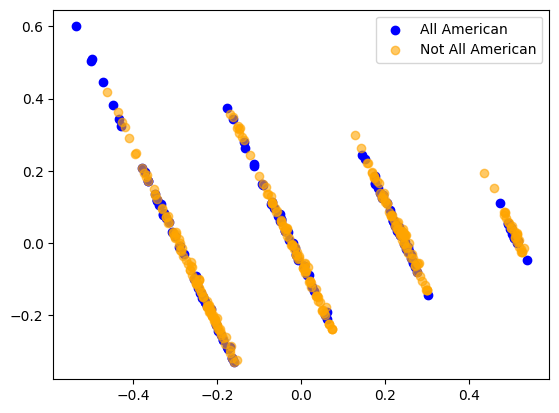

In [25]:
data = X_fr_corr
viz_pca = PCA(n_components=2)
points = viz_pca.fit_transform(data)

colors = ["blue" if x == 1 else "orange" for x in y_all_am]
all_am_indexes = y_all_am == 1

plt.scatter(x=points[all_am_indexes,0], y=points[all_am_indexes,1], c="blue")
plt.scatter(x=points[np.invert(all_am_indexes),0], y=points[np.invert(all_am_indexes),1], c="orange", alpha=0.6)
plt.legend(["All American", "Not All American"])
plt.show()

In the end, the projection into two dimensions only gives a discouraging sign as to the class seperability.

## Train Test Split

Splitting for this dataset is mildly tricky. We are assuming that event doesn't matter for predictions but we ultimately need a ranking within the event groups. With there being 18 event groups I want to split the data by 13 events for training and 5 for test which is about 72%, 28% train test split. If we want a validation set we can select 3 events from training to be a validation set.

When we do cross validation for hyperparameter tuning in part 4 we will be making multiple splits. However, we only need one for now to determine the best model to go forward with.

In [26]:
from sklearn.model_selection import train_test_split, LeavePGroupsOut, RandomizedSearchCV
import random
import math

In [27]:
random.seed(0)

def train_test_split_on_event(x_type="scaled", y_type="all_am", num_test_events=5):
    # We can try the binary classification or continuous target variable.
    y_data = y_all_am if y_type.lower() == "all_am" else y_score

    # There are multiple options to try for our data. We will try some but also explore more in part 4.
    x_type = x_type.lower()
    if x_type == "scaled":
        X_data = X_scaled
    elif x_type == "fr":
        X_data = X_fr
    elif x_type == "fr_scaled":
        X_data = X_fr_scaled
    # elif x_type == "pca":
    #     X_data = X_pca
    # elif x_type == "pca_scaled":
    #     X_data = X_pca_scaled
    else:
        X_data = X # slightly better on SVM

    test_numbers = random.choices(range(18), k=num_test_events)

    test_indices = df[df["event_num"].isin(test_numbers)].index
    X_test = X_data.iloc[test_indices]
    y_test = y_data.iloc[test_indices]

    train_indices = df[~df["event_num"].isin(test_numbers)].index
    X_train = X_data.iloc[train_indices]
    y_train = y_data.iloc[train_indices]

    return X_train, X_test, y_train, y_test

X_fr_train, X_fr_test, y_train, y_test = train_test_split_on_event(x_type="fr", y_type="all_am")
print(X_fr_train.shape)
X_scaled_train, X_scaled_test, _, _ = train_test_split_on_event(x_type="scaled", y_type="all_am")
print(X_scaled_train.shape)

(311, 7)
(311, 13)


As you can see, there are many possible different permutations of the data to consider. However, I will focus more on the feature reduced dataset and the scaled data as they both are transformations from part 2. Moreover, based on PCA cumulative variances both datasets should show improvements over the unmodified dataset.

## Model 1 - Spectral Clustering
For the unsupervised model I wanted to select a model I haven't used before and I landed on spectral clustering because I appreciate graphs and because it has many hyperparameters to  tune.

### Setup
In addition to importing the model we are going to use I am going to import two metrics recommend by [sklearn documentation](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation).

In [28]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import rand_score, fowlkes_mallows_score

While we can use the sklearn recommend metrics for evaluating unsupervised clusters, there is a way to recover the multiclass labels of the clustering algorithm into the binary classification we have. If we try the different combinations of flattening the labels to binary labels (example here)
```
Mapping = (0, 2)
Predicted = [0, 1, 1, 2, 0, 2, 3, 1]
Mapped    = [1, 0, 0, 1, 0, 1, 0, 0]
```
we can then use our traditional supervised learning metrics. Crucially, we know that we want to predict about 8 out of 24 athletes to be all_american. So, we want to find the permutation of the labels which will assign about 1/3rd of the labels to our positive class.

In [29]:
# Taken from https://stackoverflow.com/questions/1482308/how-to-get-all-subsets-of-a-set-powerset
from sklearn.metrics import f1_score
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def best_mapping(clf, y_actual):
    k_powerset = list(powerset(range(clf.n_clusters)))
    mapped = [[1 if label in mapping else 0 for label in clf.labels_] for mapping in k_powerset]
    mapped_scores = [(k_powerset[i], round(f1_score(preds, y_actual), 3), round(np.mean(preds), 3)) for i, preds in enumerate(mapped)]
    return filter(lambda vals: 0.3 < vals[2] < 0.4, sorted(mapped_scores, key=lambda tup: tup[1], reverse=True))

def print_clustering_metrics(labels_pred, y_train):
    print(f"\tRand score {round(rand_score(labels_pred, y_train), 3)}")
    print(f"\tFowlkes Mallows score {round(fowlkes_mallows_score(labels_pred, y_train), 3)}")
    print(f"\tBest (mapping, f1_score, percent_positive) {list(best_mapping(clustering, y_train))[:1]}")
    return None

### Model Training

In [30]:
# From our PCA we saw that it reached 99% variance with so 5 components, so we will try that many clusters
clustering = SpectralClustering(n_clusters=5, assign_labels="cluster_qr", random_state=0).fit(X_fr_train)
labels_pred = clustering.labels_

print("Feature reduced data")
print_clustering_metrics(labels_pred, y_train)

clustering = SpectralClustering(n_clusters=5, assign_labels="cluster_qr", random_state=0).fit(X_scaled_train)
labels_pred = clustering.labels_

print("\nScaled data")
print_clustering_metrics(labels_pred, y_train)

Feature reduced data
	Rand score 0.474
	Fowlkes Mallows score 0.358
	Best (mapping, f1_score, percent_positive) [((0, 3), 0.411, 0.386)]

Scaled data
	Rand score 0.471
	Fowlkes Mallows score 0.396
	Best (mapping, f1_score, percent_positive) [((2, 3), 0.317, 0.334)]


The two datasets have similar performance here. However, their performance is not very exciting. I want to see if we can tune the model further using the feature reduced dataset because the number of labels for SpectralClustering is at most the number of features.

In [31]:
# Decrease the number of clusters
clustering = SpectralClustering(n_clusters=2, random_state=0).fit(X_fr_train)
labels_pred = clustering.labels_

print("Feature reduced data 2 clusters")
print_clustering_metrics(labels_pred, y_train)

# Increase the number of clusters
clustering = SpectralClustering(n_clusters=X_fr_train.shape[1], random_state=0).fit(X_fr_train)
labels_pred = clustering.labels_

print(f"\nFeature reduced data {X_fr_train.shape[1]} clusters")
print_clustering_metrics(labels_pred, y_train)

Feature reduced data 2 clusters
	Rand score 0.502
	Fowlkes Mallows score 0.546
	Best (mapping, f1_score, percent_positive) [((0,), 0.329, 0.35)]

Feature reduced data 7 clusters
	Rand score 0.463
	Fowlkes Mallows score 0.319
	Best (mapping, f1_score, percent_positive) [((0, 2, 4), 0.396, 0.395)]


The model performs better on recommend metrics with two clusters however five clusters still seems to be the best. So, we will fix the number of clusters and play with other hyperparameters.

In [32]:
# Try a different affinity measure
clustering = SpectralClustering(
    n_clusters=5,
    affinity="nearest_neighbors",
    random_state=0
    ).fit(X_fr_train)
labels_pred = clustering.labels_
print(f"\nFive clusters with nearest_neighbors affinity {X_fr_train.shape[1]}")
print_clustering_metrics(labels_pred, y_train)

# Use a kernel and different method of assigning labels
clustering = SpectralClustering(
    n_clusters=5,
    affinity="poly",
    degree=3,
    assign_labels="discretize",
    random_state=0
    ).fit(X_fr_train)
labels_pred = clustering.labels_

print(f"\nFive clusters with degree 3 polynomial kernel and discretize labels")
print_clustering_metrics(labels_pred, y_train)


Five clusters with nearest_neighbors affinity 7
	Rand score 0.474
	Fowlkes Mallows score 0.374
	Best (mapping, f1_score, percent_positive) [((2, 3), 0.4, 0.389)]

Five clusters with degree 3 polynomial kernel and discretize labels
	Rand score 0.472
	Fowlkes Mallows score 0.355
	Best (mapping, f1_score, percent_positive) [((2, 3), 0.383, 0.354)]


C:\Users\mark3\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


### Spectral Clustering conclusion

There are many different permutations of hyperparameters to try here. However, there seems to be a wall at around 0.5 for the rand and fowlkes mallows score alongside a wall at 0.4 for my converted f1 score. Given how well the baseline performed, I think we can conclude that this model is not a good for the data.

## Model 2 - Logistic Regression

Since athlete performance will naturally vary it makes sense to predict a probability that an athlete will finish as an all american. Thus, logistic regression is a natural choice of model.

### Feature reduction and training

Because we have a small dataset it is actually feasible to perform an exhaustive search for the optimal feature set. I waited to do this on the supervised data as I imagine it can be helpful for both models.

I will be using the forward direction because as our baseline showed even one column is very powerful. Additionally, I will be using the f1_score metric because the labels are inbalanced thus we need a more robust metric than accuracy. If we set the number of features to be 7 based on our earlier feature reduction we get

In [76]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector

X_train, X_test, y_train, y_test = train_test_split_on_event(y_type="all_am")

In [77]:
lr = LogisticRegression(class_weight="balanced")
f1_scorer = make_scorer(f1_score)
sfs = SequentialFeatureSelector(lr, n_features_to_select=7, direction="forward", scoring=f1_scorer, cv=5)
sfs = sfs.fit(X_train, y_train)
print(sfs.get_feature_names_out())

['min' 'max' 'std' 'mean_three_worst' 'percent_diff_recent_best'
 'percent_diff_recent_worst' 'no_mark_rate']


which when compared to our original

In [35]:
X_fr.columns

Index(['max', 'std', 'mean_three_best', 'percent_diff_recent_best',
       'no_mark_rate', 'count', 'year'],
      dtype='object')

show that the two are very close sharing five features in common. Additionally, if we re-run this selection again to auto select based on a tolerance we get the following features:

In [78]:
lr = LogisticRegression(class_weight="balanced")
f1_scorer = make_scorer(f1_score)
sfs = SequentialFeatureSelector(lr, n_features_to_select="auto", direction="forward", scoring=f1_scorer, cv=5)
sfs = sfs.fit(X_train, y_train)
print(sfs.get_feature_names_out())

['min' 'std' 'mean_three_worst' 'percent_diff_recent_best'
 'percent_diff_recent_worst' 'no_mark_rate']


We will use this dataset, dubbed X_sequential, for evaluation of logistic regression.

### Evaluation

In [79]:
# See the feature importances
X_sequential = sfs.transform(X_train)
lr.fit(X_sequential, y_train)
print(sorted([(x, round(y, 3)) for x, y in zip(sfs.get_feature_names_out(), lr.coef_[0])], key=lambda tup: tup[1], reverse=True))

[('mean_three_worst', 1.786), ('std', 1.697), ('percent_diff_recent_worst', 1.381), ('percent_diff_recent_best', 1.213), ('min', 0.592), ('no_mark_rate', -0.987)]


In [80]:
# Get the scores
labels_pred = lr.predict(X_sequential)
prob_preds = lr.predict_proba(X_sequential)[:, 1] # gives probability for 0 then 1
print("Logistic regression with default params")
print(f"\tf1 score: {round(f1_score(labels_pred, y_train), 4)}")
print(f"\tpercent positive: {round(np.mean(labels_pred), 4)}")
print(f"\tall american accuracy {percent_all_american_score(None, prob_preds, X_train.index)}")

Logistic regression with default params
	f1 score: 0.5657
	percent positive: 0.4742
	all american accuracy 0.5576923076923077


The sequentially selected data gives us shockingly similar values for our metrics. However, the 56% positive is concerning as the goal is 33%. So, we will adjust the regularization to see if we can get better performances

In [81]:
for C in [0.01, 0.1, 1, 10]:
    clf = LogisticRegression(C=C, class_weight="balanced")
    clf.fit(X_sequential, y_train)

    labels_pred = clf.predict(X_sequential)
    prob_preds = clf.predict_proba(X_sequential)[:, 1] # gives probability for 0 then 1
    print(f"Logistic regression with C={C}")
    print(f"\tf1 score: {round(f1_score(labels_pred, y_train), 4)}")
    print(f"\tpercent positive: {round(np.mean(labels_pred), 4)}")
    print(f"\tall american accuracy {percent_all_american_score(None, prob_preds, X_train.index)}\n")

Logistic regression with C=0.01
	f1 score: 0.4608
	percent positive: 0.3645
	all american accuracy 0.4423076923076923

Logistic regression with C=0.1
	f1 score: 0.4679
	percent positive: 0.3677
	all american accuracy 0.47115384615384615

Logistic regression with C=1
	f1 score: 0.5657
	percent positive: 0.4742
	all american accuracy 0.5576923076923077

Logistic regression with C=10
	f1 score: 0.56
	percent positive: 0.471
	all american accuracy 0.5769230769230769



### Logistic Regression Conclusion
While lowering the regularization did improve the model performance on training data it is still not ideal. The accuracy is respectable only because it is predicting too many positive labels (note that training on full feature set increased the ratio of positive predictions even further). So, even though logistic regression confirmed that we do not need many of the features collected it still did not beat our very high baseline and does not fit the data.

## Model 3 - SVM

For the final model I want to go with SVM. The reasons for this are twofold: First, given that the two previous models have not been excellent I am hoping that the SVM kernel will bring out separability from the data. Additionally, SVM gives us a new tool in the form of regression. To recall, I prepared a "continuous" target variable `score` which we can try in addition to the binary target variable to see if this more rich data creates better predictions.

In [40]:
df[["event", "place", "score", "all_american"]].head(10)

,event,place,score,all_american
0,100,1,1.000000,1
1,100,2,0.958333,1
2,100,3,0.916667,1
3,100,4,0.875000,1
4,100,5,0.833333,1
5,100,6,0.791667,1
6,100,7,0.750000,1
7,100,8,0.708333,1
8,100,9,0.666667,0
9,100,10,0.625000,0


### SVC

To start, we will compare the available kernels for SVM. Testing showed that the scaled dataset had better performance than either the feature reduced, plain, or sequentially selected dataset so we will be using that.

In [111]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split_on_event(x_type="scaled", y_type="all_am")

In [125]:
for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    print(f"\nSVM with {kernel} kernel and default parameters")

    svm = SVC(kernel=kernel, class_weight="balanced", probability=True, random_state=0)
    svm.fit(X_train, y_train)
    preds = svm.predict(X_train)
    prob_preds = svm.predict_proba(X_train)[:, 1] # Gives 0 then 1
    print(f"\tf1 score: {round(f1_score(y_train, preds), 3)}")
    print(f"\tpercent positive: {round(np.mean(preds), 3)}")
    print(f"\tpercent correct all american {round(percent_all_american_score(None, prob_preds, X_train.index), 3)}")


SVM with linear kernel and default parameters
	f1 score: 0.543
	percent positive: 0.6
	percent correct all american 0.661

SVM with poly kernel and default parameters
	f1 score: 0.542
	percent positive: 0.513
	percent correct all american 0.67

SVM with rbf kernel and default parameters
	f1 score: 0.549
	percent positive: 0.612
	percent correct all american 0.598

SVM with sigmoid kernel and default parameters
	f1 score: 0.387
	percent positive: 0.484
	percent correct all american 0.384


There are interesting results here. Notably, sigmoid kernel performs by far the wost. Compared to logistic regression every other kernel is predicting too many positive examples but maintains a better accuracy for the all american selections. Of these, polynomial kernel seems to perform the best.

### SVR
Based on the observation that SVC predicts the probabilities well but not the classes well I am expecting SVR to perform better as it is better suited for continuous output. We will also be import two new metrics that better fit the regression problem. Note that because the score is on a scale of 1-24 we can roughly interpret the error as the difference in predicted place.

In [128]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split_on_event(x_type="scaled", y_type="score")

In [133]:
for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    print(f"\nSVR with {kernel} kernel and default parameters")

    svm = SVR(kernel=kernel)
    svm.fit(X_train, y_train)
    preds = svm.predict(X_train)

    mse = round(mean_squared_error(y_train, preds), 3)
    mae = round(mean_absolute_error(y_train, preds), 3)
    print(f"\tMSE: {mse} or roughly {round(mse*24, 3)} places")
    print(f"\tMAE: {mae} or roughly {round(mae*24, 3)} places")
    print(f"\tpercent correct all american {round(percent_all_american_score(None, preds, X_train.index), 3)}")


SVR with linear kernel and default parameters
	MSE: 0.071 or roughly 1.704 places
	MAE: 0.22 or roughly 5.28 places
	percent correct all american 0.587

SVR with poly kernel and default parameters
	MSE: 0.069 or roughly 1.656 places
	MAE: 0.215 or roughly 5.16 places
	percent correct all american 0.615

SVR with rbf kernel and default parameters
	MSE: 0.07 or roughly 1.68 places
	MAE: 0.218 or roughly 5.232 places
	percent correct all american 0.548

SVR with sigmoid kernel and default parameters
	MSE: 28.47 or roughly 683.28 places
	MAE: 4.479 or roughly 107.496 places
	percent correct all american 0.375


Once again sigmoid kernel notably worse whereas the other are comparable with polynomial kernel doing slightly better. While the SVR gives us a more tangible result through the error the performance is not a marked improvement. If we take the best performing model of the polynomial kernel we can examine the visualize the output to see that a problem lies in the distribution of predicted values.

In [140]:
svm = SVR(kernel="poly")
svm.fit(X_train, y_train)
preds = svm.predict(X_train)

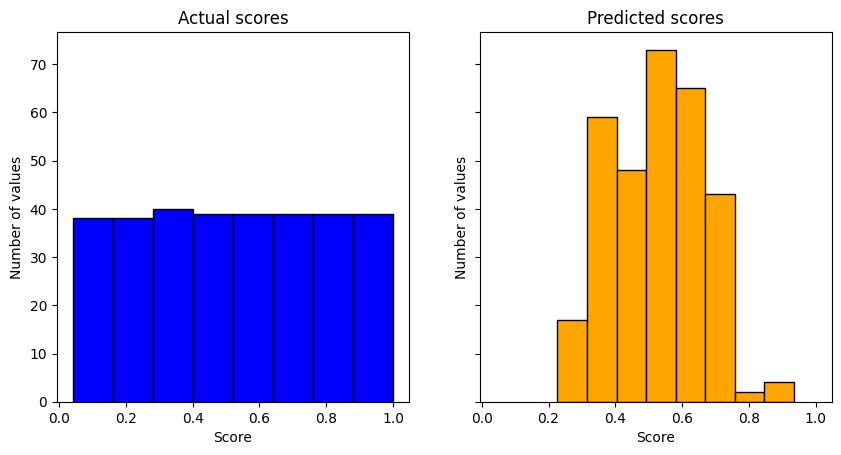

In [207]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
fig.set_figwidth(10)

# Plot actual distribution
ax1.hist(y_train, bins=8, color="blue", ec="black")
ax1.set_title("Actual scores")
ax1.set_xlabel("Score")
ax1.set_ylabel("Number of values")

ax2.hist(preds, bins=8, color="orange", ec="black")
ax2.set_title("Predicted scores")
ax2.set_xlabel("Score")
ax2.set_ylabel("Number of values")

plt.show()

Seeing that the intended distribution is perfectly normal and our model's output is clearly Guassian for my own interest I want to see if coercing the predictions into a normal distribution improves performance.

In [205]:
from sklearn.preprocessing import quantile_transform
flattened = quantile_transform(np.array(preds).reshape(-1, 1), n_quantiles=len(preds), output_distribution="uniform", random_state=0, copy=True)

print("SVR with polynomial kernel and uniform output")
mse = round(mean_squared_error(y_train, flattened), 3)
mae = round(mean_absolute_error(y_train, flattened), 3)
print(f"\tMSE: {mse} or roughly {round(mse*24, 3)} places")
print(f"\tMAE: {mae} or roughly {round(mae*24, 3)} places")
print(f"\tpercent correct all american {round(percent_all_american_score(None, flattened, X_train.index), 3)}")

SVR with polynomial kernel and uniform output
	MSE: 0.099 or roughly 2.376 places
	MAE: 0.243 or roughly 5.832 places
	percent correct all american 0.615


Ultimately, the performance is not any better than the original model output.

### SVM Conclusion

While using support vector machines I tried both classification and regression. In both cases, the polynomial kernel performed best with default parameters. Additionally, the classification model performed better on my metric of ranking top eight athletes. While SVM is the best performing model of the three it still fails to beat the baseline of predicting using only one column.

However, because SVM is the best performing model which also has a wealth of hyperparameters to tune it is the model I am choosing to optimize in part 4 of the project.

## Conclusion

Throughout this report I tried spectral clustering, logistic regression, and support vector machines as models.